<b>Author</b>: Rhondene Wint
<b>Begin</b>: August 8 2019

# Determining the expectation of tRNAs nested inside introns?

### Background:

Genes nested within the introns of protein-coding genes is a relatively common arrangement of eukaryotic genomes (Assis 2008;Kumar 2009). Most nested genes are other protein-coding genes that are antisense and functionally unrelated to their host genes (Kumar 2009, Yu 2005, Chang 2013). 85% of the nested genes are protein-coding genes (Chang 2013) and as a result previous studies focussed primarily on nested protein-coding genes. transfer RNAs are ancient biomolecules responsible for decoding the genetic information into proteins. In *Drosophila melanogaster*, while the overall nested intronic genes account for 6% of the total gene complement, I found that 130 out of the 290  tRNA genes (45%) in *D. melanogaster* are nested within the introns of 65 genes. I validated their occurence by running the tRNA gene finder tRNAscanse-2.0 (Lowe et al 2016) on the introns of these putative host genes.

<p>

<figure>
    <img src='mim_intron.jpg'>
    <figurecaption> <b>Flybase Genome Browser showing a cluster of Lys-CTT tRNA genes within the intron of the <i>missing in metastasis</i> gene</b></figurecaption>
</figure>
</p>

In this notebook I report my findings on the patterns of nested tRNA genes; wherein I examined the distribution of the nested tRNAs, compared the co-orientation and nucleotide composition with the host introns, and determined whether the occurence of nested tRNAs follows random expectaion. Finally, I analyzed the evolutionary conservation these nested tRNAs in the orthologs of the host genes of other *Drosophila* species. 
The most recent annotations files from Flybase were used as my input. 

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy.stats as stats

## How many genes host tRNAs in their introns

I answered this question in previous work. To summarise:
- Initially, using bed files I queried the tRNA genomic coordinates against coordinates of introns of all non-tRNA genes on the same chromosome, selecting for trnas that are a subset of the non-tRNA genes. Having identified the host introns, I uploaded their IDs to the Flybase feature mapper that returns the IDs of the parent genes. I then ran tRNAscanse-2.0 on the introns of the major isoforms of the putative genes. Finally, I downloaded a merged gff3 file for each parent gene that contains only their nested tRNAs.

In [3]:
merged = pd.read_table('trna_host_genes_merged.csv', sep=',')
merged.head()

,Chrom,Start,End,Strand,tRNA_ID,tRNA_name,Host_Exon_ID,intron_length,mRNA_length,Host_gene_name,...,A-content,G-content,T-content,C-content,tRNA_Sequence,A-content_trna,G-content_trna,T-content_trna,C-content_trna,Anticodon
0,3L,13249547,13249618,+,FBgn0011844,Asp-GTC-1-10-,FBtr0305480,12439,4841,caps,...,0.282901,0.208779,0.291181,0.217140,UCCUCGAUAGUAUAGUGGUUAGUAUCCCCGCCUGUCACGCGGGAGA...,0.166667,0.319444,0.236111,0.277778,GTC
1,3R,24555302,24555373,+,FBgn0011845,Asp-GTC-1-11-,FBtr0084647,325,3120,Esyt2,...,0.286154,0.172308,0.350769,0.190769,UCCUCGAUAGUAUAGUGGUUAGUAUCCCCGCCUGUCACGCGGGAGA...,0.166667,0.319444,0.236111,0.277778,GTC
2,3L,1397695,1397766,+,FBgn0011851,Glu-CTC-3-4-,FBtr0310161,126467,5167,Ptp61F,...,0.268979,0.226012,0.280136,0.224873,UCCCAUAUUGUCUAGUGGUUAGGAUAUCCGGCUCUCACCCGGAAGG...,0.194444,0.277778,0.263889,0.263889,CTC
3,3L,1397932,1398003,+,FBgn0011852,Glu-CTC-3-5-,FBtr0310161,126467,5167,Ptp61F,...,0.268979,0.226012,0.280136,0.224873,UCCCAUAUUGUCUAGUGGUUAGGAUAUCCGGCUCUCACCCGGAAGG...,0.194444,0.277778,0.263889,0.263889,CTC
4,3L,1398169,1398240,+,FBgn0011853,Glu-CTC-3-6-,FBtr0310161,126467,5167,Ptp61F,...,0.268979,0.226012,0.280136,0.224873,UCCCAUAUUGUCUAGUGGUUAGGAUAUCCGGCUCUCACCCGGAAGG...,0.194444,0.277778,0.263889,0.263889,CTC


In [3]:
print('Number of genes hosting tRNAs is: ',merged['Host_gene_name'].unique().shape[0], 'genes')

Number of genes hosting tRNAs is:  65 genes


In [4]:
##plot the number of tRNA genes in each host gene,copied code from an older notebook
gene_group = merged.groupby('Host_gene_name')
genes = merged['Host_gene_name'].unique()
##store the number of trnas for eachgene
num_trna = dict()
for g in genes:
    num = gene_group.get_group(g).shape[0] #number of rowns correspond to th number of trnas
    trnas = list(gene_group.get_group(g)['tRNA_ID'].values)
    num_trna[g]=[num,trnas]
df_counts = pd.DataFrame.from_dict(num_trna, orient='index').reset_index()
df_counts.columns = ['Gene', 'Num_of_tRNAs', 'tRNA_IDs']
df_counts.head()

,Gene,Num_of_tRNAs,tRNA_IDs
0,caps,1,[FBgn0011844]
1,Esyt2,1,[FBgn0011845]
2,Ptp61F,9,"[FBgn0011851, FBgn0011852, FBgn0011853, FBgn00..."
3,Sulf1,2,"[FBgn0011858, FBgn0012011]"
4,Wdr62,1,[FBgn0011859]


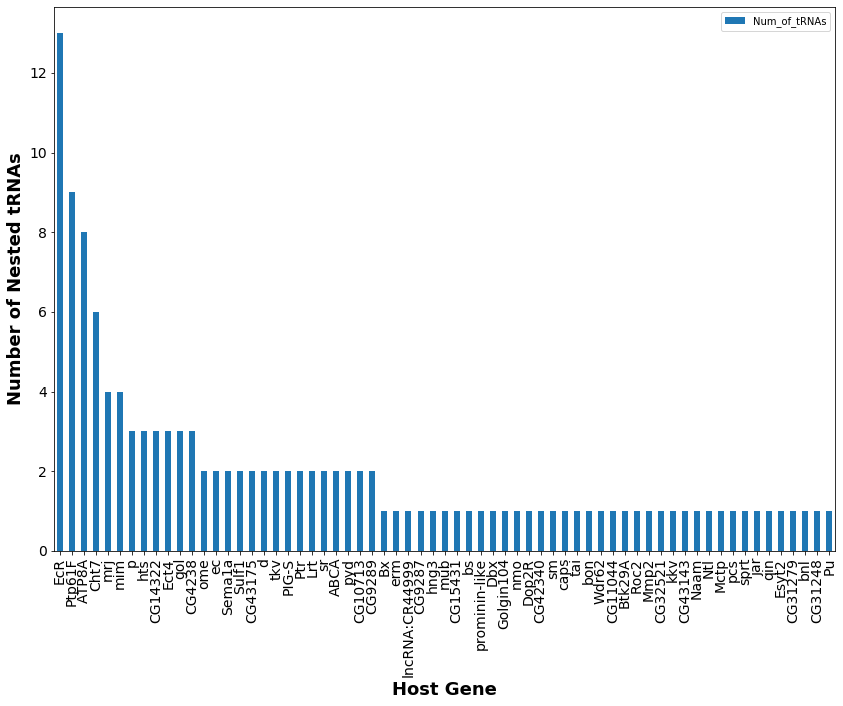

In [6]:
df_counts.sort_values(by='Num_of_tRNAs', ascending=False).plot.bar('Gene', 'Num_of_tRNAs', figsize=(14,10),legend='Off')
#plt.title('Number of nested tRNAs within the introns of each gene', fontsize=20, fontweight='bold')
plt.xlabel('Host Gene', fontweight='bold', fontsize=18)
plt.ylabel('Number of Nested tRNAs', fontweight='bold',fontsize=18)
#plt.tick_params(axis='both', left='off', top='off', right='off', bottom='on', labelleft='on', labeltop='off', labelright='off', labelbottom='on')

plt.xticks(fontsize=14);plt.yticks(fontsize=14)
plt.show()
##look a like a poisson

# 2 What is the orientation of nested tRNAs with respect to their host genes?

- In  *D.melanogaster*, Chang et al found that 71% of nested intronic protein-coding genes are on the opposite strand. They hypothesise that and the same-strand nested genes are twice as likely to be intronless compared to opposite-stranded nested genes. They reason that the fixation of nested genes are under purifying selection to minimise missplicing events or even transcriptional collision between polymerase of the host-nested gene pair.
- I found that of 130 nested tRNA genes, 52 were co-oriented with their host protein coding genes.

To determine whether a nested tRNA was co-oriented with its host, I compared the strandedness of both genes as reported in the gff3 files. I also visually inspected the gene orientations on the Flybase genome browswer. 

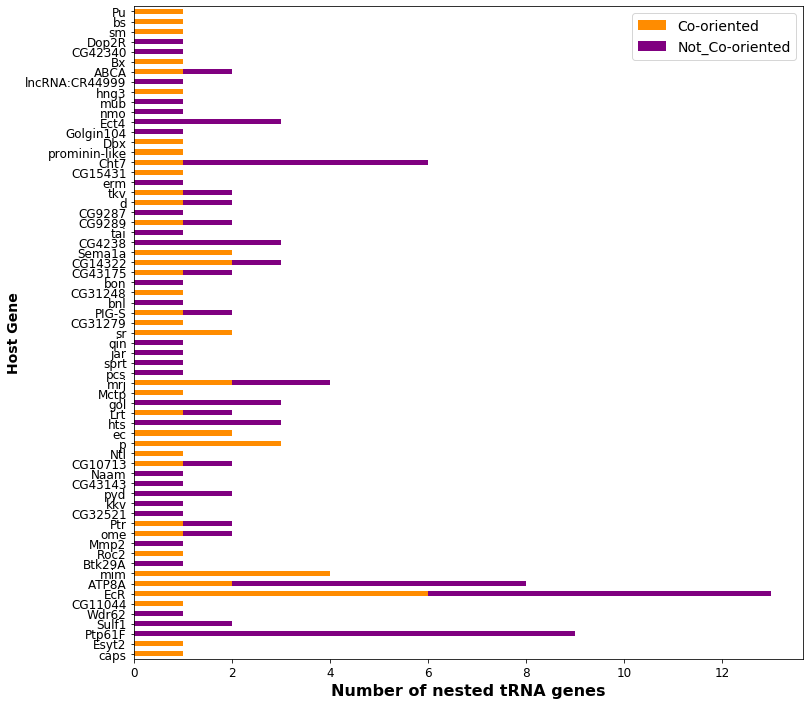

In [12]:
strand_df= pd.read_table('strandedness_coorientation.csv',sep=',')
strand_df.plot.barh(x='Gene', y=["Co-oriented", "Not_Co-oriented"], stacked=True, figsize=(12,12), 
                    color=['darkorange','purple'])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.title("Orientation of nested tRNA gene and Host PRC Gene", fontsize=14, fontweight='bold')
plt.ylabel('Host Gene', fontsize=14, fontweight='bold')
plt.xlabel('Number of nested tRNA genes', fontsize=16, fontweight='bold')
plt.legend(fontsize=14)
#plt.savefig('orientation_trnas.png', bbox_inches='tight', dpi=400)
plt.show()

## 4 Gene ontology enrichment of  the 66 host protein-coding genes

- *Why am I interested in this?*
- What do these genes that host tRNAs do. Since I am interested in hypothesis of tRNA genes are temporally expressed based on chromatin state in the host genes. If the host genes is tissue-specific expression then this address long-standing question of how identical tRNA loci are differentially regulated. Large introns can contain transcriptional regulatory elements and nested genes. The transcription of long introns also introduces a delay that contributes proper timing of expression and function of developmental genes. I have observed that several of these host genes are developmental and signal transduction genes
- I performed Gene Set Enrichment Ontology analysis using modEnrichr(Ma'yaan 2019), g:Prolifer (Uku Raudvere 2019 ) 

<b> Findings: these host genes are essential for development especially neural development. When chang et al looked at nested protein genes they found that host genes were not lethal phenotype???</b>

## GO Results using g:Prolifer

<img src='./GO_analysis/gp_bar_1.jpg' >
<p> <img src='./GO_analysis/gp_bar_labels.jpg' width='600' height='500'> <b> Table showing GO of highlighted genes  </b> </p>

In [17]:
##load the detailed csv results of gprofiler
gp_GO = pd.read_table('./GO_analysis/gProfiler_dmelanogaster_host.csv',sep=',')
gp_GO.head()

,source,term_name,term_id,adjusted_p_value,negative_log10_of_adjusted_p_value,term_size,query_size,intersection_size,effective_domain_size,intersections
0,GO:MF,binding,GO:0005488,2.206668e-02,1.656263,6649,59,48,11670,"FBGN0262579,FBGN0003162,FBGN0011225,FBGN003539..."
1,GO:BP,locomotion,GO:0040011,1.740842e-10,9.759241,672,57,22,11765,"FBGN0003162,FBGN0011225,FBGN0033438,FBGN003593..."
2,GO:BP,movement of cell or subcellular component,GO:0006928,2.004764e-08,7.697937,762,57,21,11765,"FBGN0003162,FBGN0011225,FBGN0033438,FBGN000054..."
3,GO:BP,anatomical structure morphogenesis,GO:0009653,4.032596e-07,6.394415,1555,57,27,11765,"FBGN0011225,FBGN0265598,FBGN0033438,FBGN000054..."
4,GO:BP,taxis,GO:0042330,1.235668e-06,5.908098,361,57,14,11765,"FBGN0033438,FBGN0035934,FBGN0267487,FBGN002309..."


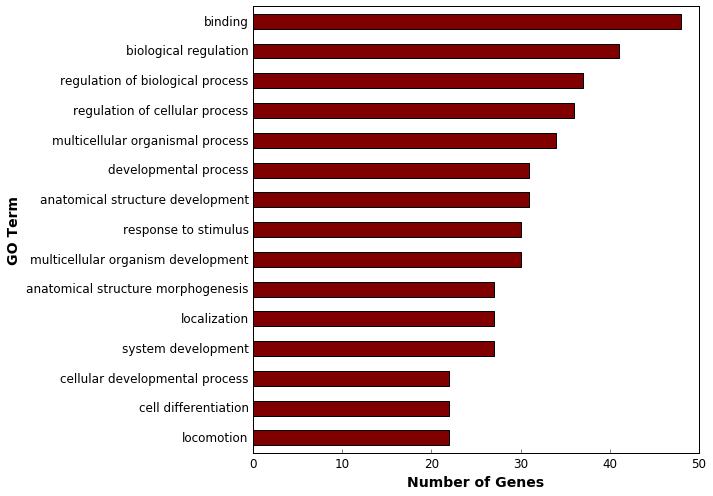

In [35]:
##plot the top 15 largest GO set
gp_GO.sort_values(by='intersection_size', ascending=True)[-15:].plot.barh('term_name','intersection_size',
                                                                   figsize=(8,8),color='maroon',legend=False)
plt.xticks(fontsize=12);plt.yticks(fontsize=12)
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='on', labelleft='on', labeltop='off', labelright='off', labelbottom='on')
plt.xlabel("Number of Genes", fontsize=14, fontweight='bold');plt.ylabel("GO Term",fontsize=14, fontweight='bold')
plt.show()

## GO Results using modEnrichr sub-tool FlyEnricher

modEnrichr provides a more diverse GO analysis, including tissue and stage-specific ontology, RNAi screens, human diseases related, etc.
- <b> Link to allResults: https://amp.pharm.mssm.edu/FlyEnrichr/enrich?dataset=603af44d7968dd96580a12667b9e0c48
- below the bar graphs are sorted by significance of adjusted p-value
<u> Biological Process GO</u>
<img src='./GO_analysis/GO_Biological_Process_2018_bar_graph.jpg'>
<p><u> Cellular Component GO </u>
<img src='./GO_analysis/GO_Cellular_Component_GeneRIF_bar_graph.jpg'></p>

<p><u> Anatomy GO </u>
<img src='./GO_analysis/modEnrichr_Anatomy_GeneRIF_bar_graph.jpg'></p>

<p><u> Phenotype  GO </u>
<img src='./GO_analysis/Phenotype_AutoRIF_Predicted_zscore_bar_graph.jpg'></p>

# 3 Determining the  Expectation of  tRNAs nested inside introns 

#### Aim: 
*Concretely, given the total space occupied by introns in the genome what is the probability that the 130/288 tRNA genes that are nested within introns occur by by random chance?*.

#### Method:
1. using the ensembl all introns bed annotation, I merged overlapping intronic regions and thensummed the them for each transcript.
2.  Then I mapped the transcript IDs to the gene ID by querying against the gtf annotation. 
3. To compute total genomic intronic nucleotides, I choose the transcript with the highest introncontent for each gene. This approach biases in favour of the null hypothesis of random nested tRNAs. Net total intronic composition was caclulated by subtracting the contribution due to nested tRNAs. 
4. I calculated total intergenic composition as the difference between the genome assembly size and total genic regions.
5. I performed two-sided and one-sided binomial test between frequency of tRNAs in introns vs in intergenic region. 
6. I repeated  the test for total intronic compositon due to only introns that over 200nt longs.
7. Here is link to jupyter notebook with code. 

<b>*Two alternative approaches for calculation introns*</b>: Two popular alternatives for estimating intron content are 1) first compute the total exonic size by first merging all overlapping exons then computing introns as the difference between genic region and sum of all non-overlapping exon regions. 2) compute intron size as the difference between the gene and the longest isoform.  However both approaches will bias in favour of shorter introns (total intron size = 64.8Mb and 57Mb respectively) . So I took the more conservative alternative by choosing the isoform of each gene with the highstest intron contet (total intron = 67Mb). 


#### Results
- <i><b> Nested intronic tRNAs do not occur more than random(two-sided binomial test, p-value = 0.72) </b> </i>
- The shortest intron to host a tRNA is 216nt. Recall that tRNAs are on average 75nt long so it would be more realistic to look at the total intron composition due to sufficiently long facillitating introns. Again, the two-sided binomial test when considrering total intron composition due 200nt and larger was also insiginifcant (p-value= 0.68).
- <b> 3'UTR tRNAs </b>. 5 tRNAs were predicted and visually confirmed in the 3'UTR region. the given the 6%  genome that is 3UTR, tRNAs in 3UTR are  occurring more than chance (two-sided p-value = 7x10-4)
#### Notes on D.mel intron
- Intron length in Dmel ranges from 44bp to >70kbp with a strong mode at 58bp. https://pdfs.semanticscholar.org/fe6a/a335e906d93d28a739b854014638b7cfa83e.pdf
- The majority (54%) of introns in Drosophila melanogaster is not longer than 81 nucleotides (nt). https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2704441/
- About 5% in Drosophila are >10 kb. An intron in the dyenin of the Y-chromosome of Dmel is 3Mb long (https://www.genetics.org/content/170/2/661)

In [59]:
print('Total intronic size {}Mb \n Total Intergenic size: {}Mb '.format(total_intron_size/1e6, intergenic))
print("Log Intergenic size: {} \n Log Intronic size {}".format(np.log(intergenic), np.log(total_intron_size)))

Total intronic size 67.561123Mb 
 Total Intergenic size: 43348712Mb 
Log Intergenic size: 17.58478754910006 
 Log Intronic size 18.02854327202742


Interestingly,  Worheide et al (2017, Genome Biol. Evol. 9(6):1582–1598. doi:10.1093/gbe/evx103) found that model animals exhibit aan approximately 1:1 intronic:intergenic ratio.

In [58]:
#since total intron size is 46% of genome what is the expectation of nesting 130 trna? 
binom_test(x=130,n=290,p=0.46,alternative='two-sided' )   

0.7238399965084523

## 4. Evolutionary Conservation and losses and gains

The *12 Drosophila Genomes Project* (cite) sequenced the 12 species of the *Drosophila genus* and annotated orthologous protein sets
- While intron position is known to be deeply conserved with evolutionary time, intronic sequences are more labile. While we found that presence of tRNAs in introns supports neutral selection, I am interested  I investigated the fixation of tRNA genes. Work done on nested protein-coding genes all support that their fixation is under purifying selection, for reasons like transcriptional collision or splicing interfernce. 
- For genomes which Flybase did not have annotated tRNAs, I re-analysed the orthologs of the host with tRNAscan-se2.0(Lowe 2016)

# Part B: Functional: Codon Usage